# Missing RPE Data

On some of the game dates, we don't have RPE data. But, we are mainly concerned with the acute/chronic ratio which we can compute for the dates for which it is missing.

In [1]:
import pandas as pd
import numpy as np
from factor_analyzer import FactorAnalyzer
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity, calculate_kmo
from scipy.stats import pointbiserialr
import matplotlib.pyplot as plt

In [2]:
np.random.seed(5151)
rpe_df = pd.read_csv('./processed_data/processed_rpe.csv')
raw_rpe = rpe_df.copy()[['Date', 'PlayerID', 'RPE']]
print(rpe_df.head())


   Unnamed: 0        Date  PlayerID  Training SessionType  Duration  RPE  \
0           0  2017-08-01        15         1    Strength      60.0  4.0   
1           1  2017-08-01         1         1       Speed      60.0  3.0   
2           2  2017-08-01         1         1    Strength      90.0  4.0   
3           3  2017-08-01         3         1       Speed      45.0  5.0   
4           4  2017-08-01         3         1    Strength      90.0  5.0   

   SessionLoad  DailyLoad  AcuteChronicRatio  ObjectiveRating  FocusRating  \
0        240.0      300.0               4.29              6.0          7.0   
1        180.0      540.0               4.29              0.0          0.0   
2        360.0      540.0               4.29              0.0          0.0   
3        225.0      675.0               4.29              7.0          7.0   
4        450.0      675.0               4.29              7.0          7.0   

   BestOutOfMyself  AcuteLoad  ChronicLoad  
0              3.0      42.86

## Drop Duplicate Dates

This occurs when there are multiple training sessions on the same date. We only care about the daily load so we can drop the duplicate sessions.

In [3]:
rpe_df = rpe_df.copy()[['Date', 'PlayerID', 'DailyLoad', 'AcuteChronicRatio', 'AcuteLoad', 'ChronicLoad']]
rpe_df.head()

,Date,PlayerID,DailyLoad,AcuteChronicRatio,AcuteLoad,ChronicLoad
0,2017-08-01,15,300.0,4.29,42.86,10.0
1,2017-08-01,1,540.0,4.29,77.14,18.0
2,2017-08-01,1,540.0,4.29,77.14,18.0
3,2017-08-01,3,675.0,4.29,96.43,22.5
4,2017-08-01,3,675.0,4.29,96.43,22.5


In [4]:
rpe_df = rpe_df.drop_duplicates()

## Fill In Missing RPE Data

In [5]:
rpe_df[rpe_df['AcuteChronicRatio'].isnull()]

,Date,PlayerID,DailyLoad,AcuteChronicRatio,AcuteLoad,ChronicLoad
265,2017-08-13,6,0.0,NaN,0.0,0.0


This row should not be in the dataset since it is the first entry for this player and they are not training.

In [6]:
rpe_df = rpe_df[~ rpe_df['AcuteChronicRatio'].isnull()]

In [7]:
rpe_df['Date'] = pd.to_datetime(rpe_df['Date'])

Adding missing dates and player ids to rpe data:

In [8]:
dates = pd.date_range(start=min(rpe_df['Date']), end=max(rpe_df['Date']))
players = rpe_df['PlayerID'].unique()
idx = pd.MultiIndex.from_product((dates, players), names=['Date', 'PlayerID'])

rpe_df = rpe_df.set_index(['Date', 'PlayerID']).reindex(idx, fill_value=0).reset_index().sort_values(by=['Date', 'PlayerID'])



Use a rolling window to compute acute load and chronic load:

In [9]:
temp = rpe_df[['Date','PlayerID','DailyLoad']].drop_duplicates()
past7Days = temp.groupby('PlayerID').rolling('7d', on='Date')['DailyLoad'].sum().reset_index()
past7Days['newAcuteLoad'] = (past7Days['DailyLoad'] / 7.).round(2)
past7Days = past7Days.drop(columns = 'DailyLoad')

rpe_df = pd.merge(rpe_df, past7Days, how='left', on=['Date', 'PlayerID'])

In [10]:
past30Days = temp.groupby('PlayerID').rolling('30d', on='Date')['DailyLoad'].sum().reset_index()
past30Days['newChronicLoad'] = (past30Days['DailyLoad'] / 30.).round(2)
past30Days = past30Days.drop(columns = 'DailyLoad')

rpe_df = pd.merge(rpe_df, past30Days, how="left", on=["Date", "PlayerID"])

In [11]:
rpe_df.drop(['ChronicLoad','AcuteLoad'],axis = 1, inplace = True)
rpe_df.rename(columns = {'newChronicLoad':'ChronicLoad','newAcuteLoad':'AcuteLoad'}, inplace = True)
rpe_df['AcuteChronicRatio'] = (rpe_df['AcuteLoad'] / rpe_df['ChronicLoad']).round(2)
rpe_df[rpe_df['PlayerID'] == 1]

,Date,PlayerID,DailyLoad,AcuteChronicRatio,AcuteLoad,ChronicLoad
0,2017-08-01,1,540.0,4.29,77.14,18.00
17,2017-08-02,1,0.0,4.29,77.14,18.00
34,2017-08-03,1,0.0,4.29,77.14,18.00
51,2017-08-04,1,0.0,4.29,77.14,18.00
68,2017-08-05,1,0.0,4.29,77.14,18.00
85,2017-08-06,1,0.0,4.29,77.14,18.00
102,2017-08-07,1,720.0,4.29,180.00,42.00
119,2017-08-08,1,0.0,2.45,102.86,42.00
136,2017-08-09,1,0.0,2.45,102.86,42.00
153,2017-08-10,1,0.0,2.45,102.86,42.00


In [12]:
gps_df = pd.read_csv('./processed_data/processed_gps.csv')
gps_df = gps_df.drop(columns=['Unnamed: 0'])
gps_df.head()


,Date,GameID,Outcome,TeamPoints,PlayerID,MaxSpeedInGame,MaxAccelImpulseInGame
0,2017-11-30,1,W,19,2,7.284728,4.423615
1,2017-11-30,1,W,19,3,6.852436,4.888893
2,2017-11-30,1,W,19,4,7.267784,5.694449
3,2017-11-30,1,W,19,6,6.338894,4.777782
4,2017-11-30,1,W,19,7,7.065283,4.091273


In [13]:
# merged_df = gps_df.merge(rpe_df, how='left', on=['Date', 'PlayerID'])
# merged_df.head()
gps_df['Date'] = pd.to_datetime(gps_df['Date'])
train_performance = gps_df.merge(rpe_df[[
    'Date','PlayerID', 'AcuteLoad',
    'ChronicLoad','AcuteChronicRatio']],
    how='left', on= ['Date','PlayerID']).drop_duplicates()
print(len(train_performance))
train_performance.head()

443


,Date,GameID,Outcome,TeamPoints,PlayerID,MaxSpeedInGame,MaxAccelImpulseInGame,AcuteLoad,ChronicLoad,AcuteChronicRatio
0,2017-11-30,1,W,19,2,7.284728,4.423615,206.57,371.20,0.56
1,2017-11-30,1,W,19,3,6.852436,4.888893,407.86,454.67,0.90
2,2017-11-30,1,W,19,4,7.267784,5.694449,236.00,406.90,0.58
3,2017-11-30,1,W,19,6,6.338894,4.777782,297.29,415.87,0.71
4,2017-11-30,1,W,19,7,7.065283,4.091273,237.57,476.60,0.50


In [14]:
wellness_df = pd.read_csv('./processed_data/processed_wellness.csv')
wellness_df = wellness_df.drop(columns=['Unnamed: 0'])
wellness_df['Date'] = pd.to_datetime(wellness_df['Date'])
wellness_df.head()

,Date,PlayerID,MonitoringScore,TrainingReadiness,Pain,Illness,Nutrition,wellness
0,2018-07-21,1,-1.450204,-1.826823,0.364611,0.301008,0.722090,-1.889318
1,2018-07-21,2,0.170622,-1.826823,-2.742646,0.301008,0.722090,-3.375750
2,2018-07-21,3,0.170622,0.795746,0.364611,0.301008,0.722090,2.354077
3,2018-07-21,4,-0.909929,0.664618,0.364611,0.301008,0.722090,1.142398
4,2018-07-21,5,0.440759,0.795746,0.364611,0.301008,-1.220149,0.681976


Impute wellness data for missing dates (if we merge without doing this there are 12 instances of performance data that have no wellness data):

In [15]:
wellness_dates = pd.date_range(start=min(train_performance['Date']), end=max(train_performance['Date']))
wellness_players = wellness_df['PlayerID'].unique()
wellness_idx = pd.MultiIndex.from_product((wellness_dates, wellness_players), names=['Date', 'PlayerID'])

wellness_df = wellness_df.set_index(['Date', 'PlayerID']).reindex(wellness_idx).reset_index().sort_values(by=['Date', 'PlayerID'])

wellness_df[wellness_df['MonitoringScore'].isnull()]

,Date,PlayerID,MonitoringScore,TrainingReadiness,Pain,Illness,Nutrition,wellness
10,2017-11-30,15,NaN,NaN,NaN,NaN,NaN,NaN
26,2017-12-01,14,NaN,NaN,NaN,NaN,NaN,NaN
35,2017-12-02,2,NaN,NaN,NaN,NaN,NaN,NaN
43,2017-12-02,14,NaN,NaN,NaN,NaN,NaN,NaN
47,2017-12-02,17,NaN,NaN,NaN,NaN,NaN,NaN
60,2017-12-03,14,NaN,NaN,NaN,NaN,NaN,NaN
61,2017-12-03,15,NaN,NaN,NaN,NaN,NaN,NaN
77,2017-12-04,14,NaN,NaN,NaN,NaN,NaN,NaN
123,2017-12-07,5,NaN,NaN,NaN,NaN,NaN,NaN
145,2017-12-08,14,NaN,NaN,NaN,NaN,NaN,NaN


In [16]:
print(len(wellness_df))

3978


We see that there are 779 observations where we need to forward fill to impute the wellness data. This is out of 3978 observations after we reindex the data which is 20% of the observations.

In [17]:
wellness_df = wellness_df.fillna(method='ffill')

In [18]:
merged_df = train_performance.merge(wellness_df,
    how='left', on= ['Date','PlayerID']).drop_duplicates()
print(len(merged_df))
merged_df.head()

443


,Date,GameID,Outcome,TeamPoints,PlayerID,MaxSpeedInGame,MaxAccelImpulseInGame,AcuteLoad,ChronicLoad,AcuteChronicRatio,MonitoringScore,TrainingReadiness,Pain,Illness,Nutrition,wellness
0,2017-11-30,1,W,19,2,7.284728,4.423615,206.57,371.20,0.56,0.981035,-1.826823,0.364611,0.301008,-1.220149,-1.400318
1,2017-11-30,1,W,19,3,6.852436,4.888893,407.86,454.67,0.90,1.251172,0.795746,0.364611,0.301008,0.722090,3.434628
2,2017-11-30,1,W,19,4,7.267784,5.694449,236.00,406.90,0.58,0.710897,0.795746,0.364611,0.301008,0.722090,2.894352
3,2017-11-30,1,W,19,6,6.338894,4.777782,297.29,415.87,0.71,0.440759,0.533489,0.364611,0.301008,0.722090,2.361958
4,2017-11-30,1,W,19,7,7.065283,4.091273,237.57,476.60,0.50,1.251172,0.664618,0.364611,0.301008,0.722090,3.303499


In [19]:
print(merged_df[merged_df['MonitoringScore'].isnull()])

Empty DataFrame
Columns: [Date, GameID, Outcome, TeamPoints, PlayerID, MaxSpeedInGame, MaxAccelImpulseInGame, AcuteLoad, ChronicLoad, AcuteChronicRatio, MonitoringScore, TrainingReadiness, Pain, Illness, Nutrition, wellness]
Index: []


In [20]:
merged_df.to_csv('./processed_data/merged_df.csv')

## Correlations Between Predictors and Response

Based on our previous analysis, we think that `AcuteChronicRatio`, `MonitoringScore`, `Pain`, `Illness`, `Nutrition` will be predictors for `MaxSpeedInGame` which is our measure for performance. We also have an overall score for wellness called `wellness` which is the combination of all predictors other than `AcuteChronicRatio`.

In [21]:
def scatter_plot(df, x, y, title=None):
    df.plot.scatter(x, y)
    if title:
        plt.title(title)
    plt.show()

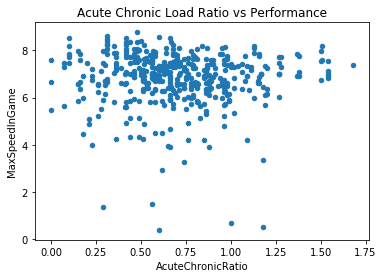

In [22]:
scatter_plot(merged_df, 'AcuteChronicRatio', 'MaxSpeedInGame', 'Acute Chronic Load Ratio vs Performance')


It does not look like there is any clear pattern between load and performance.

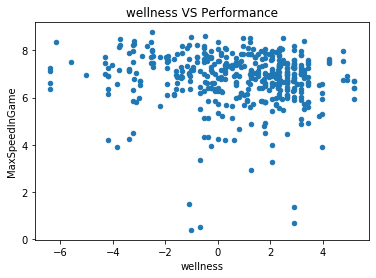

In [23]:
scatter_plot(merged_df, 'wellness', 'MaxSpeedInGame', 'wellness VS Performance')


In [24]:
merged_df['wellness'].corr(merged_df['MaxSpeedInGame'])

-0.08918453503221266

In [25]:
grouped_merged_df = merged_df[['wellness', 'MaxSpeedInGame', 'PlayerID']].groupby('PlayerID').mean()
grouped_merged_df

,wellness,MaxSpeedInGame
PlayerID,,
1,-0.744741,7.683961
2,-2.418550,6.632284
3,2.676770,6.826691
4,1.669272,6.632953
5,-0.001545,7.721914
6,1.637513,6.511335
7,1.145357,7.210339
8,1.392609,6.960623
9,0.073373,6.931128


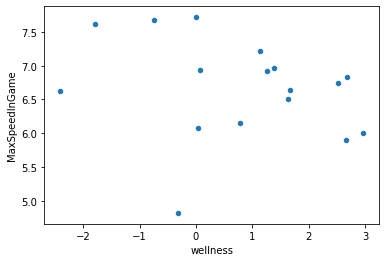

In [26]:
scatter_plot(grouped_merged_df, 'wellness', 'MaxSpeedInGame')

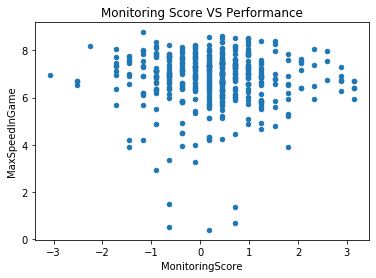

In [27]:
scatter_plot(merged_df, 'MonitoringScore', 'MaxSpeedInGame', 'Monitoring Score VS Performance')


In [28]:
merged_df['MonitoringScore'].corr(merged_df['MaxSpeedInGame'])

-0.020719221174304362

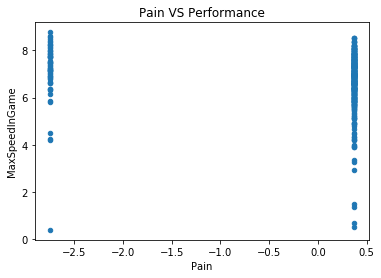

In [29]:
scatter_plot(merged_df, 'Pain', 'MaxSpeedInGame', 'Pain VS Performance')

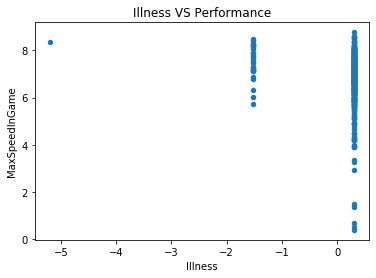

In [30]:
scatter_plot(merged_df, 'Illness', 'MaxSpeedInGame', 'Illness VS Performance')

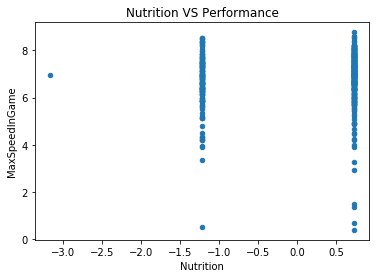

In [31]:
scatter_plot(merged_df, 'Nutrition', 'MaxSpeedInGame', 'Nutrition VS Performance')

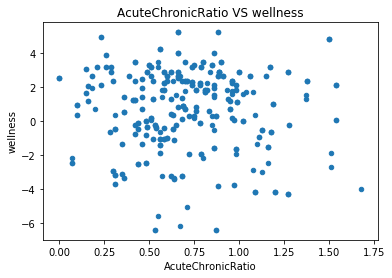

In [32]:
scatter_plot(merged_df, 'AcuteChronicRatio', 'wellness', 'AcuteChronicRatio VS wellness')

## Ideas Going Forward

It does not seem like we will be able to fit a model to this data. We could average the data and plot that. We could also split the players into high and low values and see if there is a significant difference in average performance for the different groups.

We could also go back and explore the load prior to games and see if players are at the optimal of 0.8 during games. We can also take a closer look at the repeated measure correlations of the wellness data. 

Could also look at subjective performance vs wellness.

We also need to investigate the affect of wellness on load independent of performance. For example, look at the daily load to next day's wellness. Also look at wellness to current daily load (ie, does wellness affect RPE?).

### Regression Examples

In [33]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [34]:
merged_df['SquaredAcuteChronicRatio'] = merged_df['AcuteChronicRatio'] ** 2
merged_df['CubedAcuteChronicRatio'] = merged_df['AcuteChronicRatio'] ** 3

fam = sm.families.Gaussian()
ind = sm.cov_struct.Autoregressive()
mod = smf.gee("MaxSpeedInGame ~ AcuteChronicRatio + SquaredAcuteChronicRatio +  wellness", "PlayerID", merged_df, cov_struct=ind, family=fam)
res = mod.fit()
print(res.summary())

                               GEE Regression Results                              
Dep. Variable:              MaxSpeedInGame   No. Observations:                  443
Model:                                 GEE   No. clusters:                       17
Method:                        Generalized   Min. cluster size:                   5
                      Estimating Equations   Max. cluster size:                  38
Family:                           Gaussian   Mean cluster size:                26.1
Dependence structure:       Autoregressive   Num. iterations:                     8
Date:                     Sun, 01 Dec 2019   Scale:                           1.304
Covariance type:                    robust   Time:                         13:58:33
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                    7.1690      0.447     16.044 

In [35]:
mixed = smf.mixedlm("MaxSpeedInGame ~ AcuteChronicRatio + SquaredAcuteChronicRatio +  wellness", merged_df, groups = merged_df["PlayerID"])
mixed_fit = mixed.fit()
print(mixed_fit.summary())

               Mixed Linear Model Regression Results
Model:               MixedLM   Dependent Variable:   MaxSpeedInGame
No. Observations:    443       Method:               REML          
No. Groups:          17        Scale:                1.0099        
Min. group size:     5         Likelihood:           -653.6281     
Max. group size:     38        Converged:            Yes           
Mean group size:     26.1                                          
-------------------------------------------------------------------
                         Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------------------
Intercept                 6.939    0.287 24.215 0.000  6.377  7.501
AcuteChronicRatio        -0.747    0.617 -1.211 0.226 -1.956  0.462
SquaredAcuteChronicRatio  0.459    0.380  1.208 0.227 -0.286  1.205
wellness                  0.013    0.028  0.470 0.639 -0.042  0.068
Group Var                 0.440    0.186                       

## RPE and Wellness

In [36]:
raw_rpe['Date'] = pd.to_datetime(raw_rpe['Date'])
rpe_wellness = wellness_df.merge(raw_rpe, on=['Date', 'PlayerID'])
rpe_wellness.head()

,Date,PlayerID,MonitoringScore,TrainingReadiness,Pain,Illness,Nutrition,wellness,RPE
0,2017-11-30,1,-0.639791,0.271233,0.364611,0.301008,0.722090,1.019150,7.0
1,2017-11-30,1,-0.639791,0.271233,0.364611,0.301008,0.722090,1.019150,2.0
2,2017-11-30,1,-0.639791,0.271233,0.364611,0.301008,0.722090,1.019150,4.0
3,2017-11-30,2,0.981035,-1.826823,0.364611,0.301008,-1.220149,-1.400318,1.0
4,2017-11-30,2,0.981035,-1.826823,0.364611,0.301008,-1.220149,-1.400318,6.0


In [37]:
rpe_wellness['RPE'].corr(rpe_wellness['wellness'])


0.07881801947580373

In [38]:
grouped_rpe_wellness = rpe_wellness[['PlayerID', 'wellness', 'RPE']].groupby(['PlayerID']).mean()
grouped_rpe_wellness

,wellness,RPE
PlayerID,,
1,-1.526518,3.462462
2,-2.261942,4.249267
3,1.811773,5.066667
4,1.611573,4.691667
5,-0.954863,4.281081
6,1.170127,5.056250
7,1.181044,4.709581
8,-2.105934,4.289062
9,-0.605270,4.059603


In [39]:
grouped_rpe_wellness.corr()

,wellness,RPE
wellness,1.00000,0.37907
RPE,0.37907,1.00000


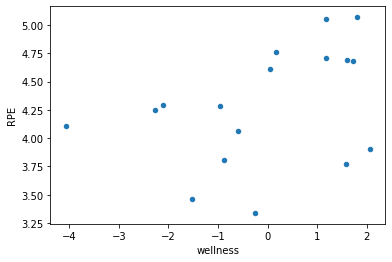

In [40]:
grouped_rpe_wellness.plot.scatter('wellness', 'RPE')